In [321]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2,
                        strongGravityMode=False,
                        gravity=1.5,

                        # Log
                        verbose=True)

# **Reading in the data**

In [36]:
import pandas as pd
import numpy as np
import re
import networkx as nx
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import community
import itertools
import networkx.algorithms.community as nx_comm
from networkx.algorithms import bipartite
import re
import csv
from fa2 import ForceAtlas2
import community


folder = "../Movie Dataframe with Ratings/"
df1 = pd.read_pickle(folder+"networkData1.pkl")
df2 = pd.read_pickle(folder+"networkData2.pkl")
df3 = pd.read_pickle(folder+"networkData3.pkl")

frames = [df1, df2, df3]
moviesDf = pd.concat(frames, axis=0, ignore_index=True)


In [2]:
actor_column = list(moviesDf["Actors"].to_numpy())
actors = [actor for cast in actor_column for actor in cast]
duplicates = set(actors) & set(moviesDf["MovieTitle"].to_numpy())
duplicates

# Removing movies where an Actor is called the same
moviesDf.drop(moviesDf[moviesDf['MovieTitle'].isin(duplicates)].index, inplace = True)

**Extracting relevant columns**

In [3]:
genres = (moviesDf['Genres'].to_numpy())
rating_column = moviesDf['Rating'].to_numpy()
genre_column = [re.findall(r"'name': '(.*?)'}", s) for s in genres]
title_column = moviesDf["MovieTitle"].to_numpy()
actor_column = list(moviesDf["Actors"].to_numpy())


#Only using 5 actors
#actor_column5 = []
#for actors in (actor_column):
#    actor_column5.append(actors[:5])
#actor_column = actor_column5
    
actorsDistinct = [*set([actor for cast in actor_column for actor in cast])]

# Creating the graph

**Generating the bipartite network of Actors and Movies**

In [414]:
G = nx.Graph()

#G.add_nodes_from(title_column, bipartite=0)
for i, title in enumerate((title_column)):
    G.add_node(title, bipartite=0, Genres = genre_column[i])
    
G.add_nodes_from(actorsDistinct, bipartite=1)


for i, movie in enumerate(title_column):
    # Adding links between each movie and its actors
    G.add_edges_from(list(zip(itertools.repeat(movie), actor_column[i])))

'Jumanji'

In [5]:
bipartite.is_bipartite(G)

True

**Basic stats**

In [6]:
print(f'Nodes: {G.number_of_nodes()}')
print(f'Edges: {G.number_of_edges()}\n')

Nodes: 137704
Edges: 255020



**Extracting the projected Actor Network and the Movie Network from the biparite graph**

In [7]:
actorNodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 1}
movieNodes = {n for n, d in G.nodes(data=True) if d["bipartite"] == 0}

actorNetwork = bipartite.weighted_projected_graph(G, actorNodes, ratio = False)
movieNetwork = bipartite.weighted_projected_graph(G, movieNodes, ratio = False)

In [8]:
print(f'Actor network stats')
print(f'Nodes: {actorNetwork.number_of_nodes()}')
print(f'Edges: {actorNetwork.number_of_edges()}\n')

print(f'Movie network stats')
print(f'Nodes: {movieNetwork.number_of_nodes()}')
print(f'Edges: {movieNetwork.number_of_edges()}\n')

Actor network stats
Nodes: 131746
Edges: 8086719

Movie network stats
Nodes: 5958
Edges: 468645



# Testing stuff

In [9]:
movieEdges = sorted(nx.get_edge_attributes(movieNetwork, 'weight').items(), key=lambda x: x[1], reverse = True)
actorEdges = sorted(nx.get_edge_attributes(actorNetwork, 'weight').items(), key=lambda x: x[1], reverse = True)

In [10]:
movieDegrees = sorted(movieNetwork.degree(weight='weight'), key=lambda x: x[1], reverse=True)
actorDegrees = sorted(actorNetwork.degree(weight='weight'), key=lambda x: x[1], reverse=True)

# Extracting backbone of network

In [11]:
from backbone import *

In [12]:
actorAlphaNetwork = disparity_filter(actorNetwork)
movieAlphaNetwork = disparity_filter(movieNetwork)

In [504]:
#alphaActor = 0.1
alphaActor = 0.12
actorNetworkBackbone = nx.Graph([(u, v, d) for u, v, d in actorAlphaNetwork.edges(data=True) if d['alpha'] < alphaActor])
alphaMovie = 0.12
movieNetworkBackbone = nx.Graph([(u, v, d) for u, v, d in movieAlphaNetwork.edges(data=True) if d['alpha'] < alphaMovie])

In [505]:
#sorted(nx.get_edge_attributes(actorNetworkBackbone, 'alpha').items(), key=lambda x: x[1], reverse = False)
#sorted(nx.get_edge_attributes(actorNetworkBackbone, 'weight').items(), key=lambda x: x[1], reverse = False)

In [506]:
print(f'Actor network backbone stats')
print(f'Nodes: {actorNetworkBackbone.number_of_nodes()}')
print(f'Edges: {actorNetworkBackbone.number_of_edges()}\n')

print(f'Movie network backbone stats')
print(f'Nodes: {movieNetworkBackbone.number_of_nodes()}')
print(f'Edges: {movieNetworkBackbone.number_of_edges()}\n')

Actor network backbone stats
Nodes: 5802
Edges: 23271

Movie network backbone stats
Nodes: 3860
Edges: 13205



In [507]:
movieBackboneDegrees = sorted(movieNetworkBackbone.degree(weight='weight'), key=lambda x: x[1], reverse=True)
actorBackboneDegrees = sorted(actorNetworkBackbone.degree(weight='weight'), key=lambda x: x[1], reverse=True)
actorBackboneDegreesValues = [val for name, val in actorBackboneDegrees]
movieBackboneDegreesValues = [val for name, val in movieBackboneDegrees]

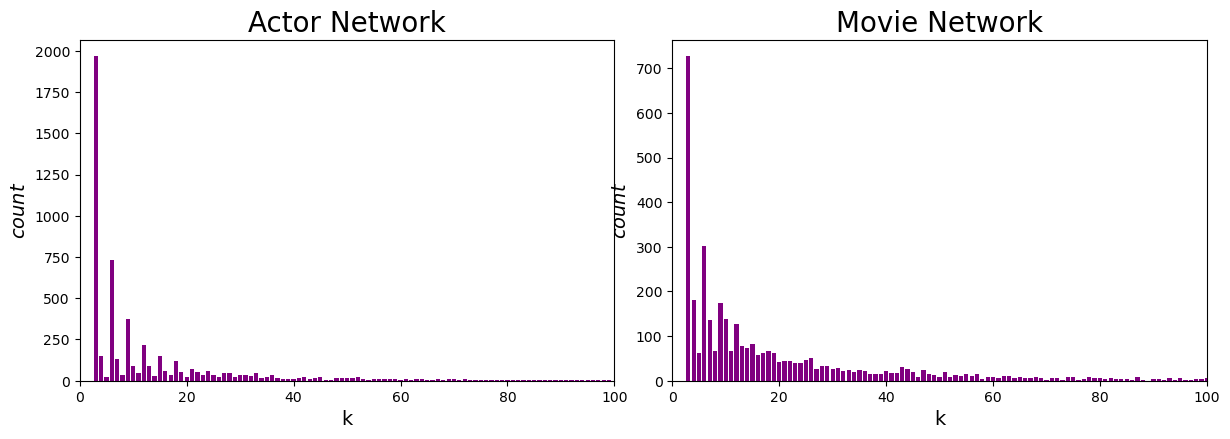

In [508]:
# Binning actors
b = np.arange(np.min(actorBackboneDegreesValues),np.max(actorBackboneDegreesValues),1)
actorFreq, actorBins = np.histogram(actorBackboneDegreesValues, bins = b);
#p_k_sune = [i/np.sum(freq) for i in freq]

# Binning Movies
b = np.arange(np.min(movieBackboneDegreesValues),np.max(movieBackboneDegreesValues),1)
movieFreq, movieBins = np.histogram(movieBackboneDegreesValues, bins = b);
#p_k_sune = [i/np.sum(freq) for i in freq]

# Plotting
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
fig.tight_layout()
ax1.set_title('Actor Network', fontsize = 20)
ax1.set_xlabel('k', fontsize = 14)
ax1.set_ylabel('$count$', fontsize = 14)
ax1.bar(actorBins[:-1], actorFreq, color = 'purple');
ax1.set_xlim(0,100);

ax2.set_title('Movie Network', fontsize = 20)
ax2.set_xlabel('k', fontsize = 14)
ax2.set_ylabel('$count$', fontsize = 14)
ax2.bar(movieBins[:-1], movieFreq, color = 'purple');
ax2.set_xlim(0,100);
plt.show()

# Plotting network Actors

In [509]:
# Removing nodes with very small degree (might be illegal)
remove = [node for node,degree in dict(actorNetworkBackbone.degree()).items() if degree < 4]
actorNetworkBackbone.remove_nodes_from(remove)

In [510]:
# Extracting largest connected component
nodes = max(nx.connected_components(actorNetworkBackbone), key=len)
actorNetworkBackbone = actorNetworkBackbone.subgraph(nodes).copy()

In [511]:
positions = forceatlas2.forceatlas2_networkx_layout(actorNetworkBackbone, pos=None, iterations=100);

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.17it/s]

BarnesHut Approximation  took  1.46  seconds
Repulsion forces  took  3.59  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.06  seconds


In [512]:
d = dict(actorNetworkBackbone.degree).values()
scale = 1
node_size = [degree*scale for degree in d]

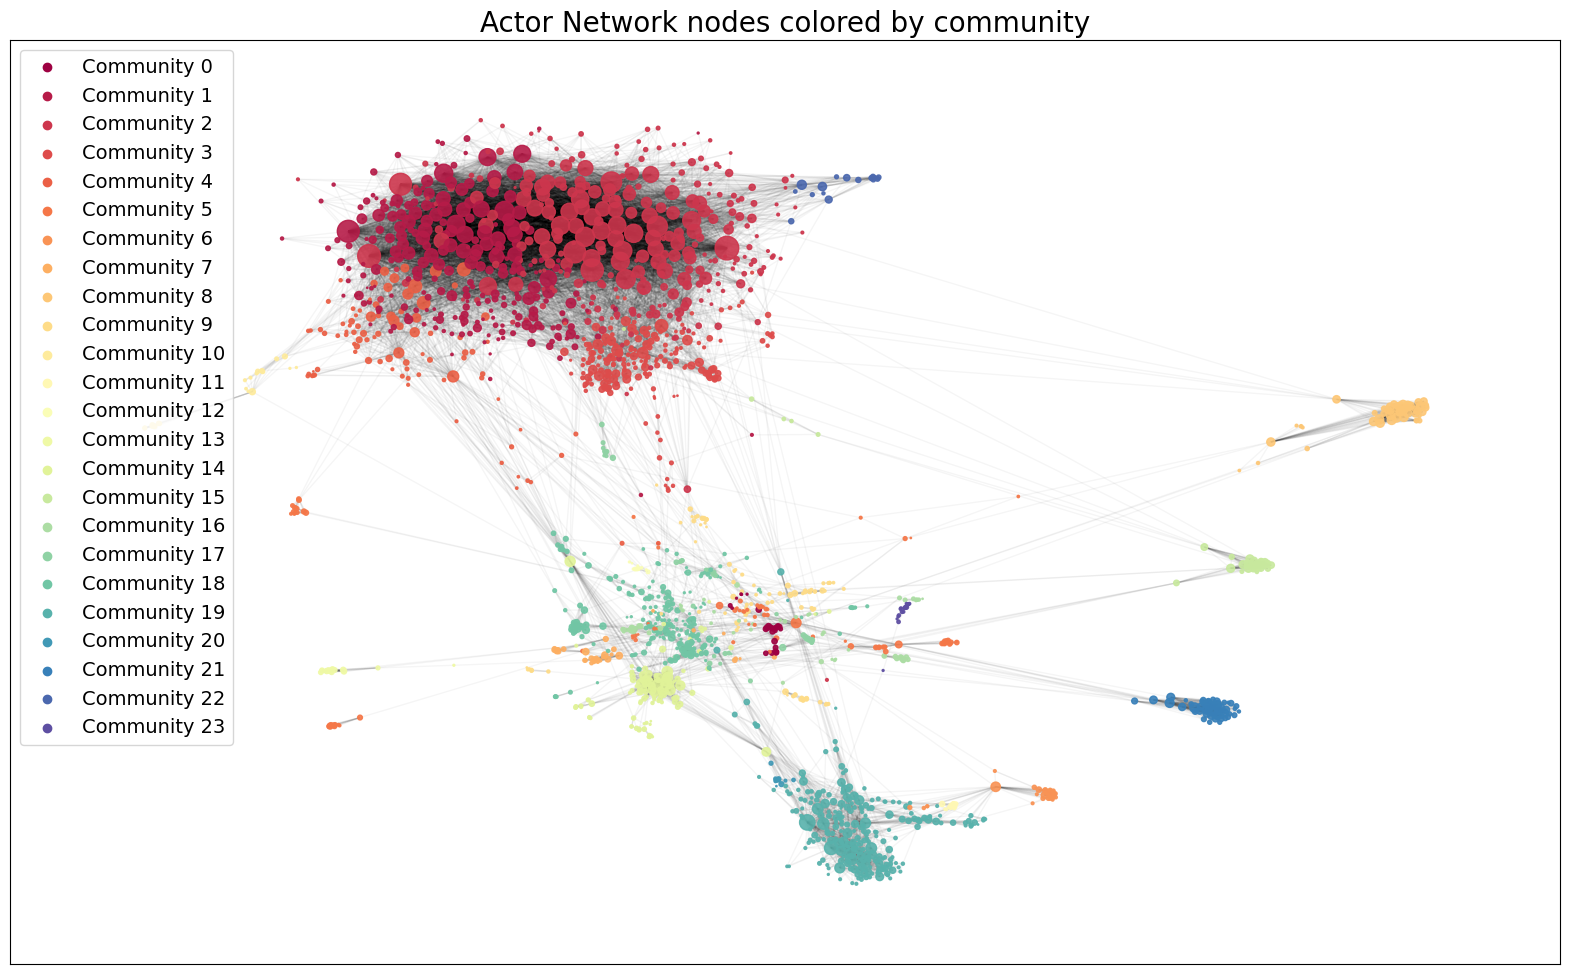

In [513]:
# Best partition found with louvain algorithm
partition = community.best_partition(actorNetworkBackbone, random_state = 1, randomize = False)

# Defining values for the color spectrum
maxval = np.max(list(partition.values())) 
cmap=plt.cm.Spectral
node_color = [cmap(v/maxval) for v in partition.values()]

# Plotting
fig = plt.figure(1,figsize=(20,12)) 
nx.draw_networkx_nodes(actorNetworkBackbone, pos = positions, node_color=node_color, alpha=0.9, node_size = node_size);
nx.draw_networkx_edges(actorNetworkBackbone, pos = positions, alpha=0.04);

# For legend creation only
for v in set(partition.values()):
    plt.scatter([],[], c=[cmap(v/maxval)], label='Community {}'.format(v))

plt.title('Actor Network nodes colored by community', fontsize = 20)
plt.legend(loc='upper left', prop={'size': 14})
plt.savefig('actorNetwork.png')
plt.show()



In [514]:
# rearanging found partition
partsActor = []
for i in range(0, len(set(partition.values()))):
    partsActor.append([])
    
for actor, com in partition.items():
    partsActor[com].append(actor)

#sorting based on biggest communities
partsActorSorted = partsActor
partsActorSorted.sort(key=len, reverse = True)

# Plotting network Movies


In [515]:
# Removing nodes with very small degree (might be illegal)
remove = [node for node,degree in dict(movieNetworkBackbone.degree()).items() if degree < 6]
movieNetworkBackbone.remove_nodes_from(remove)

In [516]:
# Extracting largest connected component
nodes = max(nx.connected_components(movieNetworkBackbone), key=len)
movieNetworkBackbone = movieNetworkBackbone.subgraph(nodes).copy()

In [517]:
positions = forceatlas2.forceatlas2_networkx_layout(movieNetworkBackbone, pos=None, iterations=100);

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.80it/s]

BarnesHut Approximation  took  1.30  seconds
Repulsion forces  took  1.75  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.04  seconds


In [518]:
d = dict(movieNetworkBackbone.degree).values()
scale = 4
node_size = [degree*scale for degree in d]

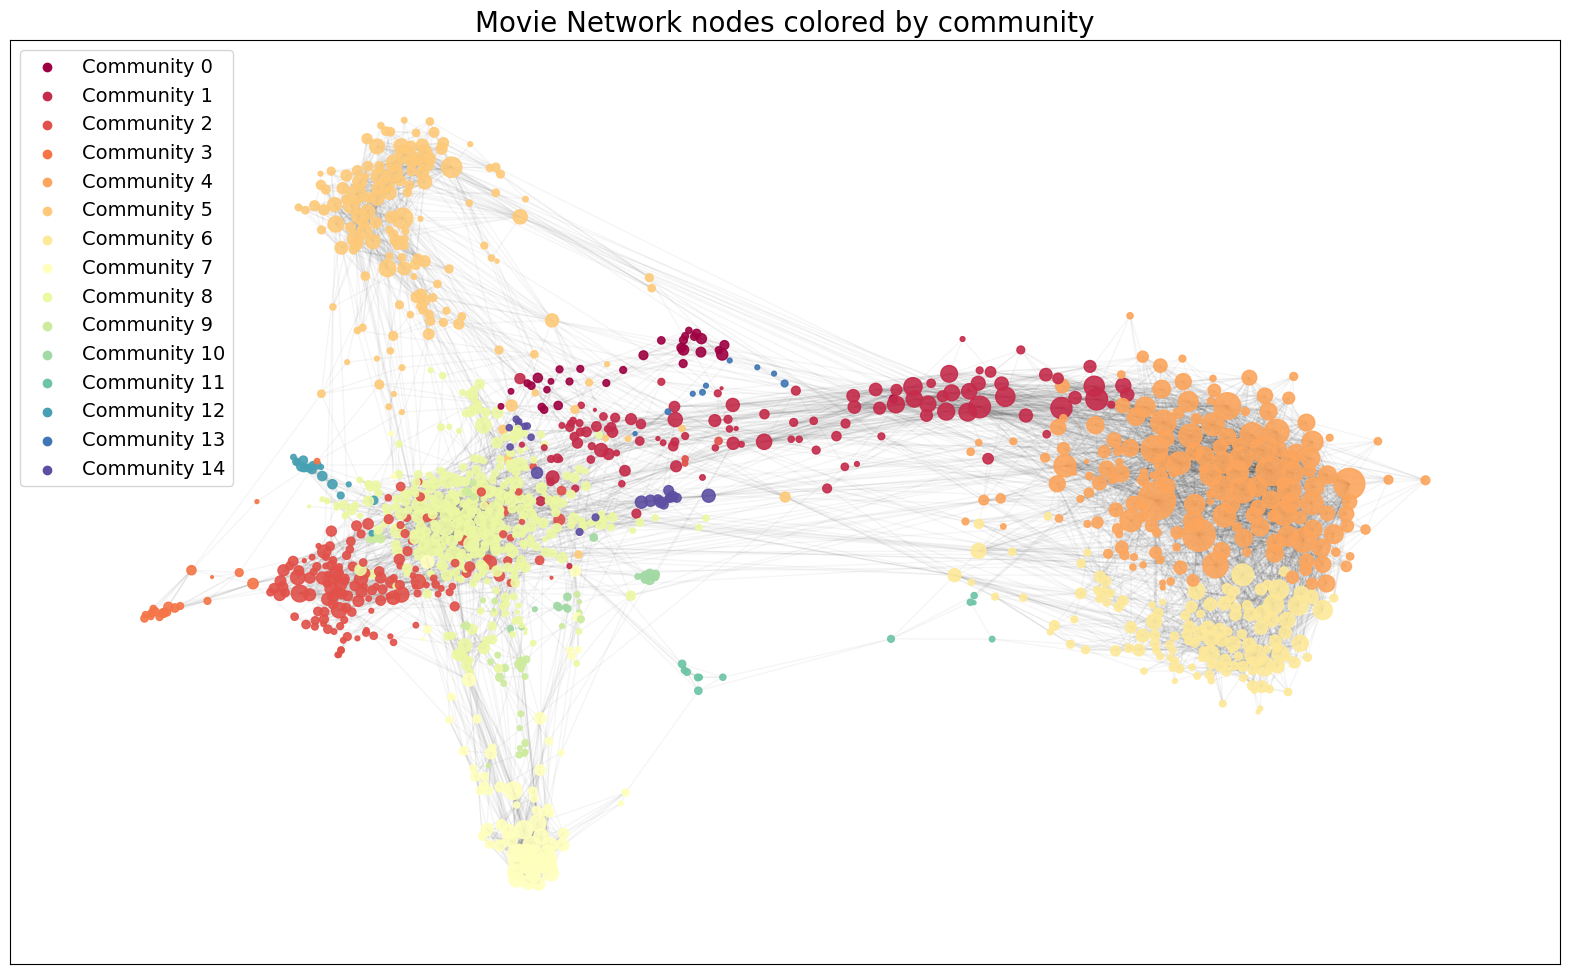

In [519]:
# Best partition found with louvain algorithm
partition = community.best_partition(movieNetworkBackbone, random_state = 1, randomize = False)

# Defining values for the color spectrum
maxval = np.max(list(partition.values())) 
cmap=plt.cm.Spectral
node_color = [cmap(v/maxval) for v in partition.values()]

# Plotting
plt.figure(1,figsize=(20,12)) 
nx.draw_networkx_nodes(movieNetworkBackbone, pos = positions, node_color=node_color, alpha=0.9, node_size = node_size);
nx.draw_networkx_edges(movieNetworkBackbone, pos = positions, alpha=0.04);

# For legend creation only
for v in set(partition.values()):
    plt.scatter([],[], c=[cmap(v/maxval)], label='Community {}'.format(v))

plt.title('Movie Network nodes colored by community', fontsize = 20)
plt.legend(loc='upper left', prop={'size': 14})
plt.savefig('movieNetwork.png')
plt.show()

In [520]:
# rearanging found partition
partsMovie = []
for i in range(0, len(set(partition.values()))):
    partsMovie.append([])
    
for actor, com in partition.items():
    partsMovie[com].append(actor)
    
#sorting based on biggest communities
partsMovieSorted = partsMovie
partsMovieSorted.sort(key=len, reverse = True)

# Analysing found communities

In [521]:
communitySizeActor = [len(com) for com in partsActor]
communitySizeMovie = [len(com) for com in partsMovie]
print(communitySizeActor)
print(communitySizeMovie)

[288, 245, 241, 238, 181, 110, 96, 91, 88, 60, 48, 48, 47, 38, 37, 31, 28, 23, 19, 17, 16, 14, 12, 12]
[344, 169, 152, 147, 126, 112, 72, 41, 31, 22, 21, 20, 19, 12, 9]


In [529]:
for i in partsActor:
    print(i[:5])


['Franklyn Farnum', 'Leoda Richards', 'Bert Stevens', 'Brandon Beach', 'Norman Stevans']
['Julia Faye', 'Chuck Hamilton', 'Dorothy Vernon', 'William Meader', 'Jack Lemmon']
['Marshall Dancing Elk Lucas', 'Michael Rapaport', 'Jack Warden', 'Brion James', 'Woody Allen']
['John Gielgud', 'Guy Standeven', 'Harry Fielder', 'Trevor Howard', 'Desmond Llewelyn']
['Bert Moorhouse', 'Leo White', 'James Stewart', 'James Flavin', 'George Anderson']
['Jack Riley', 'Tress MacNeille', 'Michael Bell', 'Whoopi Goldberg', 'Kath Soucie']
['Sean Stone', 'Oliver Stone', 'Biff Yeager', 'Ed Pansullo', 'Del Zamora']
['Danny Nero', 'Bob Harks', 'Stan Rodarte', 'Hank Robinson', 'Conrad Hurtt']
['Peter Jason', 'Allan Graf', 'Greg Bronson', 'Dennis Quaid', 'Luis Contreras']
['John Candy', 'James Rebhorn', 'Randy Quaid', 'Daniel von Bargen', 'Matthew Lillard']
['Lin Shaye', 'Chris Elliott', 'Scott Grimes', 'Don Keith Opper', 'Edward Chiodo']
['Anjelica Huston', 'Jack Nicholson', 'Christina Ricci', 'Christopher Llo

In [523]:
print(f'Actor network backbone stats')
print(f'Nodes: {actorNetworkBackbone.number_of_nodes()}')
print(f'Edges: {actorNetworkBackbone.number_of_edges()}\n')

print(f'Movie network backbone stats')
print(f'Nodes: {movieNetworkBackbone.number_of_nodes()}')
print(f'Edges: {movieNetworkBackbone.number_of_edges()}\n')

Actor network backbone stats
Nodes: 2028
Edges: 18202

Movie network backbone stats
Nodes: 1297
Edges: 8805



In [524]:
movieBackboneDegrees = sorted(movieNetworkBackbone.degree(), key=lambda x: x[1], reverse=True)
actorBackboneDegrees = sorted(actorNetworkBackbone.degree(), key=lambda x: x[1], reverse=True)

In [343]:
actorBackboneDegrees

[('Bert Stevens', 280),
 ('Sam Harris', 255),
 ('Norman Stevans', 216),
 ('Arthur Tovey', 214),
 ('Bess Flowers', 212),
 ('James Gonzalez', 190),
 ('Hans Moebus', 184),
 ('Jeffrey Sayre', 177),
 ('Herschel Graham', 177),
 ('Harold Miller', 172),
 ('John Roy', 166),
 ('Michael Jeffers', 166),
 ('Rudy Germane', 165),
 ('Dick Cherney', 164),
 ('Stuart Holmes', 163),
 ('Frank McLure', 161),
 ('Franklyn Farnum', 160),
 ('Paul Power', 155),
 ('Paul Bradley', 154),
 ('Stuart Hall', 154),
 ('Robert Locke Lorraine', 146),
 ('Fred Rapport', 143),
 ('Joe Ploski', 143),
 ('Chet Brandenburg', 139),
 ('Chuck Hamilton', 138),
 ('Charles Morton', 135),
 ('Shep Houghton', 134),
 ('William Meader', 134),
 ('Cosmo Sardo', 131),
 ('Leoda Richards', 130),
 ('George Bruggeman', 129),
 ('Raoul Freeman', 129),
 ('Paul Cristo', 125),
 ('Guy Standeven', 123),
 ('Frank Baker', 122),
 ('Jimmie Horan', 119),
 ('Thomas Martin', 116),
 ('Robert Haines', 115),
 ('Scott Seaton', 112),
 ('Brandon Beach', 111),
 ('Berna

In [378]:
list(bipartite.maximum_matching(G, partsActor[-2]))

['Brett Rice',
 'Marc Macaulay',
 'Richard Fitzpatrick',
 'Al Quinn',
 'Antoni Corone',
 'Deborah Smith Ford',
 'Johnathan Hodges',
 'Afemo Omilami',
 'Kitty Kavey',
 'Orlando Delbert',
 'Trish Dempsey',
 'David Dwyer',
 'Out of Sight',
 'Just Cause',
 'Rocky V',
 'The War',
 'Big Trouble',
 'Fair Game',
 'Up Close & Personal',
 'The Perez Family',
 'Analyze This',
 'Gordy',
 'Two If by Sea',
 'Fluke']

In [370]:
partsActor[-1]

['Kenneth Branagh',
 'Michael Maloney',
 'Kenneth W Caravan',
 'Helena Bonham Carter',
 'Richard Briers',
 'Edward Jewesbury',
 'Jimmy Yuill',
 'Richard Clifford',
 'Emma Thompson',
 'Brian Blessed',
 'Ian Holm',
 'Patrick Doyle']

In [416]:
genrelist = nx.get_node_attributes(G, 'Genres')

In [445]:
com = partsMovie[6]
genreAtt = G.nodes(data='Genres')
for movie in com:
    print(f'{movie:<40}{genreAtt[movie][0]}')

Final Fantasy: The Spirits Within       Adventure
Casual Sex?                             Comedy
Gross Anatomy                           Comedy
The Crow                                Fantasy
Oliver & Company                        Animation
Men at Work                             Comedy
黑侠                                      Action
Some Kind of Wonderful                  Drama
Dinosaur                                Animation
もののけ姫                                   Adventure
The Lion King                           Family
Lilo & Stitch                           Animation
Jaws: The Revenge                       Adventure
The Fabulous Baker Boys                 Music
Amazon Women on the Moon                Comedy
Babe: Pig in the City                   Adventure
Small Soldiers                          Comedy
Toy Story                               Animation
The Prince of Egypt                     Adventure
Eight Crazy Nights                      Comedy
The Iron Giant                    